Loading MNIST dataset from parquet file...
Parquet file columns: Index(['image', 'label'], dtype='object')
Number of samples: 60000
Processing image data...
Image type: <class 'dict'>
Dictionary keys: dict_keys(['bytes', 'path'])
Extracting images from PNG byte data...
Processing image 0/60000
Processing image 1000/60000
Processing image 2000/60000
Processing image 3000/60000
Processing image 4000/60000
Processing image 5000/60000
Processing image 6000/60000
Processing image 7000/60000
Processing image 8000/60000
Processing image 9000/60000
Processing image 10000/60000
Processing image 11000/60000
Processing image 12000/60000
Processing image 13000/60000
Processing image 14000/60000
Processing image 15000/60000
Processing image 16000/60000
Processing image 17000/60000
Processing image 18000/60000
Processing image 19000/60000
Processing image 20000/60000
Processing image 21000/60000
Processing image 22000/60000
Processing image 23000/60000
Processing image 24000/60000
Processing image 2

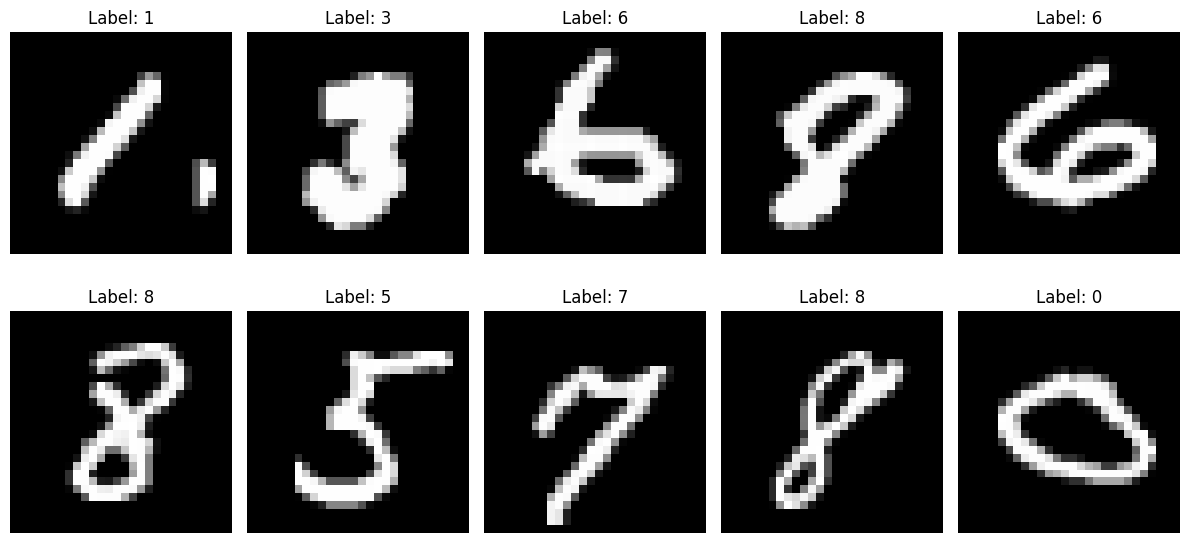

Using device: cpu
Epoch [1/30], Train Loss: 0.737316, Valid Loss: 0.704477
Epoch [2/30], Train Loss: 0.698642, Valid Loss: 0.695768
Epoch [3/30], Train Loss: 0.690763, Valid Loss: 0.690323
Epoch [4/30], Train Loss: 0.686627, Valid Loss: 0.688162
Epoch [5/30], Train Loss: 0.684370, Valid Loss: 0.686059
Epoch [6/30], Train Loss: 0.682182, Valid Loss: 0.685161
Epoch [7/30], Train Loss: 0.681110, Valid Loss: 0.684319
Epoch [8/30], Train Loss: 0.680080, Valid Loss: 0.682564
Epoch [9/30], Train Loss: 0.679388, Valid Loss: 0.682455
Epoch [10/30], Train Loss: 0.678416, Valid Loss: 0.682142
Epoch [11/30], Train Loss: 0.677728, Valid Loss: 0.681900
Epoch [12/30], Train Loss: 0.677494, Valid Loss: 0.681558
Epoch [13/30], Train Loss: 0.677187, Valid Loss: 0.681614
Epoch [14/30], Train Loss: 0.676446, Valid Loss: 0.681455
Epoch [15/30], Train Loss: 0.676104, Valid Loss: 0.681610
Epoch [16/30], Train Loss: 0.675959, Valid Loss: 0.679535
Epoch [17/30], Train Loss: 0.675723, Valid Loss: 0.679516
Epoch

c:\Users\Asif\Documents\my_env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


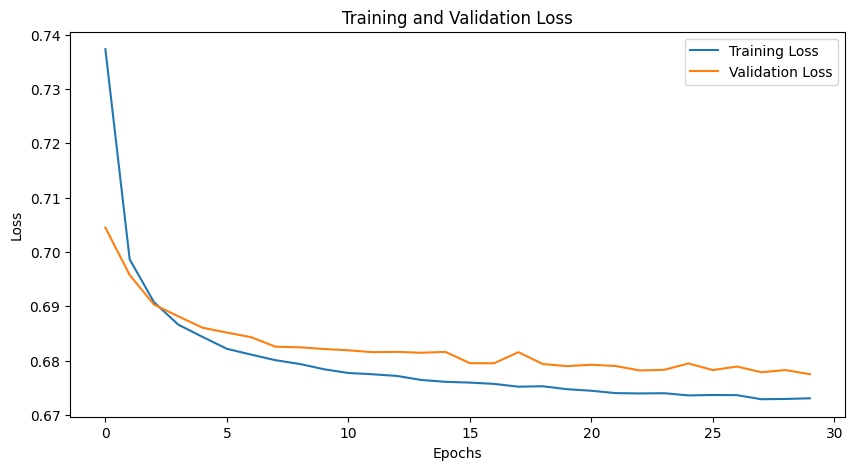

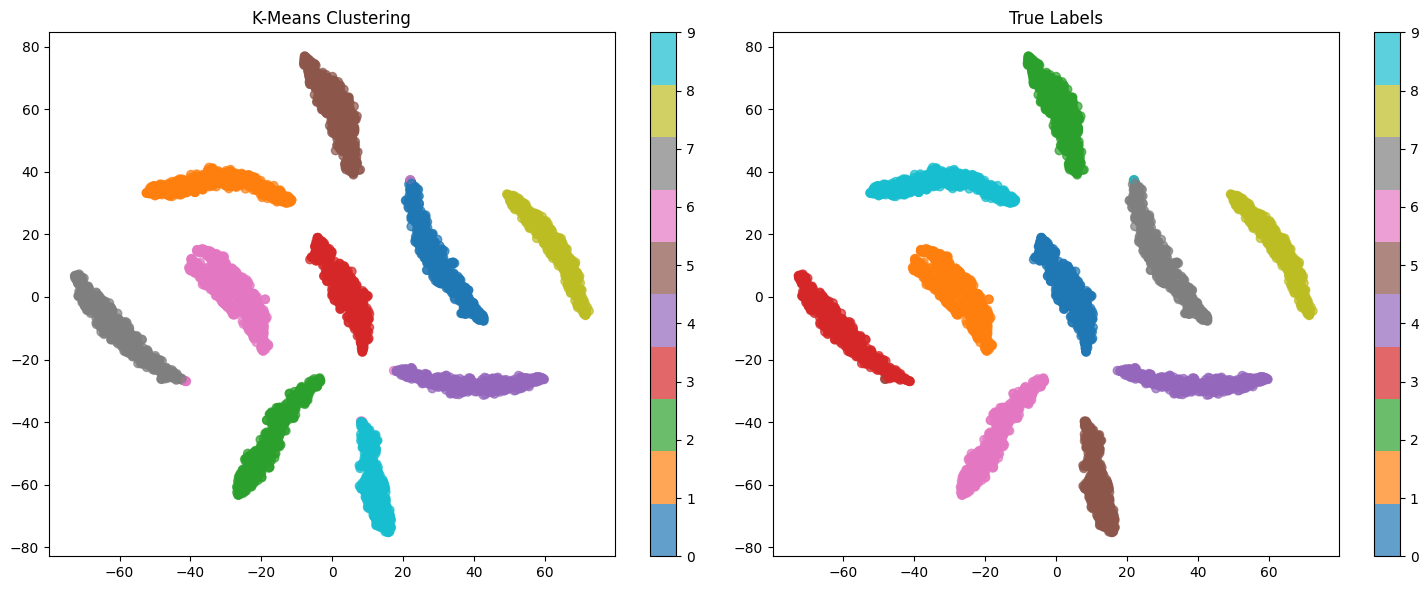

Visualization saved to 'enhanced_mnist_clustering2.png'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import io
from PIL import Image
import torch.nn.functional as F

parquet_path = r"C:\Users\Asif\Downloads\train.parquet"
parquet_data = pq.read_table(parquet_path).to_pandas()

print(f"Parquet file columns: {parquet_data.columns}")
print(f"Number of samples: {len(parquet_data)}")


images = []
labels = []
sample_img = parquet_data['image'].iloc[0]

for i, row in enumerate(parquet_data.itertuples()):
    if i % 1000 == 0:
        print(f"Processing image {i}/{len(parquet_data)}")

    img_bytes = row.image['bytes']

    img_pil = Image.open(io.BytesIO(img_bytes))

    img_array = np.array(img_pil)

    if len(img_array.shape) == 3 and img_array.shape[2] > 1:
        img_array = np.mean(img_array, axis=2).astype(np.uint8)

    images.append(img_array)
    labels.append(row.label)


image_data = np.stack(images)
label_data = np.array(labels)

print(f"Successfully extracted {len(images)} images")
print(f"Image data shape: {image_data.shape}")
print(f"Label data shape: {label_data.shape}")

train_images = torch.tensor(image_data, dtype=torch.float32)
train_labels = torch.tensor(label_data, dtype=torch.long)

train_images = train_images / 255.0

train_images = train_images.unsqueeze(1)

print(f"Final tensor shape: {train_images.shape}")

from sklearn.model_selection import train_test_split
indices = np.arange(len(train_images))
train_idx, valid_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=label_data)

valid_images = train_images[valid_idx]
valid_labels = train_labels[valid_idx]
train_images = train_images[train_idx]
train_labels = train_labels[train_idx]

print(f"Data loaded successfully.")
print(f"Train set: {len(train_images)} images")
print(f"Validation set: {len(valid_images)} images")


batch_size = 128
train_dataset = TensorDataset(train_images, train_labels)
valid_dataset = TensorDataset(valid_images, valid_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i, 0].numpy(), cmap='gray')
    plt.title(f"Label: {train_labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('mnist_samples22.png')
plt.show()

class EnhancedAutoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2), 
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2), 
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 64 * 7 * 7),
            nn.BatchNorm1d(64 * 7 * 7),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

def contrastive_loss(embeddings, labels, temperature=0.5):
    batch_size = embeddings.size(0)
    labels = labels.contiguous().view(-1, 1)
    
    mask = torch.eq(labels, labels.T).float()
    mask = mask.fill_diagonal_(0)
    
    embeddings_normalized = F.normalize(embeddings, p=2, dim=1)
    
    logits = torch.matmul(embeddings_normalized, embeddings_normalized.T) / temperature
    logits = logits - torch.max(logits, dim=1, keepdim=True)[0] 

    exp_logits = torch.exp(logits)
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True))

    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1).clamp(min=1e-8)
    
    return -mean_log_prob_pos.mean()

def train_enhanced_model(model, train_loader, valid_loader, epochs=30, alpha=0.8, beta=0.2):
    device = next(model.parameters()).device
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    recon_criterion = nn.MSELoss()
    train_losses = []
    valid_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            
            recon, z = model(data)
            
            rec_loss = recon_criterion(recon, data)
            cont_loss = contrastive_loss(z, labels)
            loss = alpha * rec_loss + beta * cont_loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for data, labels in valid_loader:
                data, labels = data.to(device), labels.to(device)
                recon, z = model(data)
                
                rec_loss = recon_criterion(recon, data)
                cont_loss = contrastive_loss(z, labels)
                loss = alpha * rec_loss + beta * cont_loss
                
                valid_loss += loss.item()
        
        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.6f}, "
              f"Valid Loss: {valid_loss:.6f}")
        scheduler.step(valid_loss)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('enhanced_training_history2.png')
    
    return model

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    labels = []
    
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            _, z = model(data)
            embeddings.append(z.cpu().numpy())
            labels.append(target.numpy())
    
    return np.vstack(embeddings), np.concatenate(labels)

def improved_clustering(embeddings, true_labels):
   
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    
    n_clusters_range = [8, 9, 10, 11, 12]
    silhouette_scores = []
    
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, n_init=30, max_iter=500, random_state=42)
        cluster_labels = kmeans.fit_predict(scaled_embeddings)
        score = silhouette_score(scaled_embeddings, cluster_labels)
        silhouette_scores.append(score)
        print(f"K-Means with {n_clusters} clusters - Silhouette Score: {score:.4f}")

    best_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
    print(f"\nBest number of clusters: {best_n_clusters}")

    kmeans = KMeans(n_clusters=best_n_clusters, n_init=50, max_iter=1000, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_embeddings)
    
    silhouette = silhouette_score(scaled_embeddings, cluster_labels)
    davies_bouldin = davies_bouldin_score(scaled_embeddings, cluster_labels)
    
    print(f"Final Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    
    return cluster_labels, scaled_embeddings

def main():
 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = EnhancedAutoencoder(latent_dim=10).to(device)
    
    model = train_enhanced_model(model, train_loader, valid_loader, epochs=30)
    
    print("Extracting embeddings...")
    embeddings, true_labels = extract_embeddings(train_loader, model)
    print(f"Embeddings shape: {embeddings.shape}")

    print("Performing improved clustering...")
    cluster_labels, scaled_embeddings = improved_clustering(embeddings, true_labels)

    print("Generating t-SNE visualization...")
    subset_size = min(5000, len(embeddings))
    subset_indices = np.random.choice(len(embeddings), subset_size, replace=False)
    
    tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, learning_rate=200, random_state=42)
    reduced_embeddings = tsne.fit_transform(scaled_embeddings[subset_indices])

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    scatter1 = axes[0].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                              c=cluster_labels[subset_indices], cmap='tab10', alpha=0.7)
    axes[0].set_title("K-Means Clustering")
    plt.colorbar(scatter1, ax=axes[0])

    scatter2 = axes[1].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                              c=true_labels[subset_indices], cmap='tab10', alpha=0.7)
    axes[1].set_title("True Labels")
    plt.colorbar(scatter2, ax=axes[1])
    
    plt.tight_layout()
    plt.savefig('enhanced_mnist_clustering2.png')
    plt.show()
    print("Visualization saved to 'enhanced_mnist_clustering2.png'")

if __name__ == "__main__":
    main()